In [35]:
!pip install gurobipy
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB

In [36]:
# read the csv files
url = "https://raw.githubusercontent.com/ethandavenport/Optimization-I-Project-1/main/stocks2019.csv"
stocks19 = pd.read_csv(url, index_col=0).drop(columns=['NDX'])

url = "https://raw.githubusercontent.com/ethandavenport/Optimization-I-Project-1/main/stocks2020.csv"
stocks20 = pd.read_csv(url, index_col=0).drop(columns=['NDX'])

# Task 1

In [37]:
stocks19.iloc[:5]

,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,ADI,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
X,,,,,,,,,,,,,,,,,,,,,
2019-01-02,46.350380,224.570007,18.830000,98.050003,202.119995,1054.680054,1045.849976,1539.130005,182.458298,82.851608,...,27.590000,247.970001,147.759995,107.364159,164.080002,63.920757,159.740005,36.312473,46.041862,84.600266
2019-01-03,44.704514,215.699997,17.049999,100.209999,184.779999,1025.469971,1016.059998,1500.280029,179.681961,77.846962,...,26.959999,243.360001,142.589996,104.083450,163.729996,63.253742,154.020004,33.835327,45.860447,81.414970
2019-01-04,46.488358,226.190002,19.000000,106.000000,186.710007,1078.069946,1070.709961,1575.390015,185.824142,79.736969,...,28.549999,255.029999,148.970001,108.678413,172.699997,65.358139,163.350006,35.268467,46.309223,85.184715
2019-01-07,47.799141,229.259995,20.570000,107.940002,189.919998,1075.920044,1068.390015,1629.510010,188.324738,80.238388,...,29.180000,271.000000,151.399994,108.787117,175.850006,65.733910,163.500000,36.521275,46.108707,87.434891
2019-01-08,49.247898,232.679993,20.750000,108.610001,192.949997,1085.369995,1076.280029,1656.579956,190.739777,82.195892,...,29.480000,276.000000,156.919998,109.755516,178.190002,67.049149,166.949997,36.170105,46.643410,85.769180


In [38]:
returns19 = stocks19.pct_change().dropna(how="all")
returns20 = stocks20.pct_change().dropna(how="all")
returns19.iloc[:5]

,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,ADI,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
X,,,,,,,,,,,,,,,,,,,,,
2019-01-03,-0.035509,-0.039498,-0.094530,0.022030,-0.085791,-0.027696,-0.028484,-0.025242,-0.015216,-0.060405,...,-0.022834,-0.018591,-0.034989,-0.030557,-0.002133,-0.010435,-0.035808,-0.068217,-0.003940,-0.037651
2019-01-04,0.039903,0.048632,0.114370,0.057779,0.010445,0.051294,0.053786,0.050064,0.034184,0.024278,...,0.058976,0.047954,0.044744,0.044147,0.054785,0.033269,0.060577,0.042356,0.009786,0.046303
2019-01-07,0.028196,0.013573,0.082632,0.018302,0.017192,-0.001994,-0.002167,0.034353,0.013457,0.006288,...,0.022067,0.062620,0.016312,0.001000,0.018240,0.005749,0.000918,0.035522,-0.004330,0.026415
2019-01-08,0.030309,0.014918,0.008751,0.006207,0.015954,0.008783,0.007385,0.016612,0.012824,0.024396,...,0.010281,0.018450,0.036460,0.008902,0.013307,0.020009,0.021101,-0.009615,0.011597,-0.019051
2019-01-09,0.017210,0.011819,-0.026988,0.012430,0.038196,-0.003427,-0.001505,0.001714,-0.001196,0.025340,...,0.023745,0.018804,-0.008157,0.003781,0.023065,0.012050,-0.004612,0.044083,-0.007984,0.008972


# Task 2

In [39]:
returns_np = returns19.values
N, n = returns_np.shape
beta = 0.95
R = 0.0002  # Minimum required average daily return

# Calculate daily mean returns for each stock
mean_returns = returns_np.mean(axis=0)

# === GUROBI MODEL ===
m = gp.Model("minimize_CVaR")

# Variables
x = m.addMVar(n, lb=0, ub=1, name="weights")
alpha = m.addVar(lb=-GRB.INFINITY, name="VaR")
z = m.addMVar(N, lb=0, name="aux_shortfall")  # z_t >= 0

# Constraints
m.addConstr(x.sum() == 1, name="weights_sum")
m.addConstr(x @ mean_returns >= R, name="min_mean_return")
m.addConstrs((z[t] >= -returns_np[t, :] @ x - alpha for t in range(N)), name="shortfall")

# Objective
obj = alpha + (1/(N*(1-beta))) * z.sum()
m.setObjective(obj, GRB.MINIMIZE)

# Solve
m.Params.OutputFlag = 0
m.optimize()

# Parameters from optimization (expressed as percentages)
mean_return = x.X @ mean_returns * 100
VaR = alpha.X * 100
CVaR = m.objVal * 100

# Results
print("Optimal weights:", x.X)
print("Optimal mean return:", round(mean_return, 2), "%")
print("Optimal VaR (alpha):", round(-VaR, 2), "%")
print("Optimal CVaR:", round(-CVaR, 2), "%")

Optimal weights: [0.         0.         0.         0.         0.         0.
 0.         0.         0.08076593 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.26496489 0.0626959  0.         0.         0.06561376 0.01963614
 0.         0.         0.03035228 0.03431195 0.         0.
 0.         0.02348597 0.         0.05215454 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.01978987 0.         0.04050981
 0.         0.         0.         0.00180162 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         

In [40]:
weights = pd.DataFrame([x.X], columns=returns19.columns)
weights.iloc[-5:]

,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,ADI,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.080766,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.303917,0.0


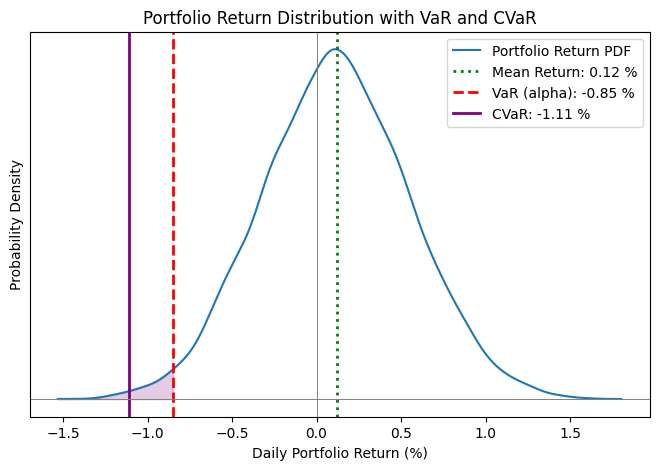

In [41]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.stats import norm

z_beta = norm.ppf(beta)  # Quantile for the standard normal distribution
scale = (VaR - mean_return) / z_beta

# Generate simulated returns centered at mean_return
np.random.seed(0)
simulated_returns = np.random.normal(loc=mean_return, scale=scale, size=10000)

# Kernel density estimate for probability density function (pdf)
kde = gaussian_kde(simulated_returns)
x_vals = np.linspace(min(simulated_returns), max(simulated_returns), 1000)
pdf_vals = kde(x_vals)

# Plot the pdf
plt.figure(figsize=(8,5))
plt.plot(x_vals, pdf_vals, label='Portfolio Return PDF')

# Mark lines
plt.axvline(mean_return, color='g', linestyle=':', linewidth=2, label=f'Mean Return: {mean_return:.2f} %') # Mark mean return
plt.axvline(-VaR, color='r', linestyle='--', linewidth=2, label=f'VaR (alpha): {-VaR:.2f} %') # Mark VaR (quantile point)
plt.axvline(-CVaR, color='purple', linestyle='-', linewidth=2, label=f'CVaR: {-CVaR:.2f} %') # Mark CVaR (expected tail loss)

# Shade tail region (returns <= VaR)
x_fill = x_vals[x_vals <= -VaR]
plt.fill_between(x_fill, 0, kde(x_fill), color='purple', alpha=0.2)

plt.title('Portfolio Return Distribution with VaR and CVaR')
plt.xlabel('Daily Portfolio Return (%)')
plt.ylabel('Probability Density')
ax = plt.gca()
ax.yaxis.set_ticks([])
ax.set_yticklabels([])
ax.grid(False)
ax.axhline(0, color='gray', linestyle='-', linewidth=0.7)
ax.axvline(0, color='gray', linestyle='-', linewidth=0.7)

plt.legend()
plt.show()

# Task 2A

In [42]:
# x.X: numpy array (n_stocks,) from 2019
# returns_20: DataFrame (n_days_2020, n_stocks), daily returns

# Compute daily portfolio returns for 2020 (not losses; returns are positive if portfolio gains)
daily_portfolio_returns = returns20.values @ x.X

# To calculate CVaR, focus on the tail of the loss distribution (worst returns)
sorted_returns = np.sort(daily_portfolio_returns)  # Sort returns: worst to best
losses = -sorted_returns  # Convert to losses, as CVaR is about loss

# Empirical quantile (VaR at beta)
VaR_idx = int(np.ceil((1-beta) * len(losses)))
VaR = losses[VaR_idx]  # VaR (quantile loss)

# CVaR: the mean of losses worse than VaR
CVaR = losses[:VaR_idx+1].mean()

print(f"Empirical daily average {int(beta*100)}%-CVaR in 2020: {CVaR*100:.4f}%")


Empirical daily average 95%-CVaR in 2020: 4.4351%


# Task 2B

In [43]:
url = "https://raw.githubusercontent.com/ethandavenport/Optimization-I-Project-1/main/stocks2019.csv"
ndx19 = pd.read_csv(url, index_col=0)['NDX']

url = "https://raw.githubusercontent.com/ethandavenport/Optimization-I-Project-1/main/stocks2020.csv"
ndx20 = pd.read_csv(url, index_col=0)['NDX']

ndxreturns19 = ndx19.pct_change().dropna(how="all")
ndxreturns20 = ndx20.pct_change().dropna(how="all")

# NDX daily returns for 2019 and 2020
ndx_returns_19 = ndxreturns19.values  # For 2019
ndx_returns_20 = ndxreturns20.values  # For 2020

# Compute CVaR for 2019
ndx_losses_19 = -np.sort(ndx_returns_19)
VaR_idx_19 = int(np.ceil((1-beta) * len(ndx_losses_19)))
VaR_ndx_19 = ndx_losses_19[VaR_idx_19]
CVaR_ndx_19 = ndx_losses_19[:VaR_idx_19+1].mean()

# Compute CVaR for 2020
ndx_losses_20 = -np.sort(ndx_returns_20)
VaR_idx_20 = int(np.ceil((1-beta) * len(ndx_losses_20)))
VaR_ndx_20 = ndx_losses_20[VaR_idx_20]
CVaR_ndx_20 = ndx_losses_20[:VaR_idx_20+1].mean()

print(f"Empirical daily average {int(beta*100)}%-CVaR of NDX (2019): {-CVaR_ndx_19*100:.4f}%")
print(f"Empirical daily average {int(beta*100)}%-CVaR of NDX (2020): {-CVaR_ndx_20*100:.4f}%")


Empirical daily average 95%-CVaR of NDX (2019): -2.3788%
Empirical daily average 95%-CVaR of NDX (2020): -5.4675%


In-sample 2019 empirical 95%-VaR (loss): 0.8500%
In-sample 2019 empirical 95%-CVaR (loss): 1.0990%
Out-of-sample 2020 empirical 95%-VaR (loss): 2.5389%
Out-of-sample 2020 empirical 95%-CVaR (loss): 4.5830%
NDX 2019 95%-CVaR: 2.4414% loss
NDX 2020 95%-CVaR: 5.5892% loss

--- CVaR Comparison (loss %)

Portfolio 2019 (in-sample) CVaR: 1.0990%
Portfolio 2020 (out-of-sample) CVaR: 4.5830%
NDX 2019 CVaR: 2.4414%
NDX 2020 CVaR: 5.5892%


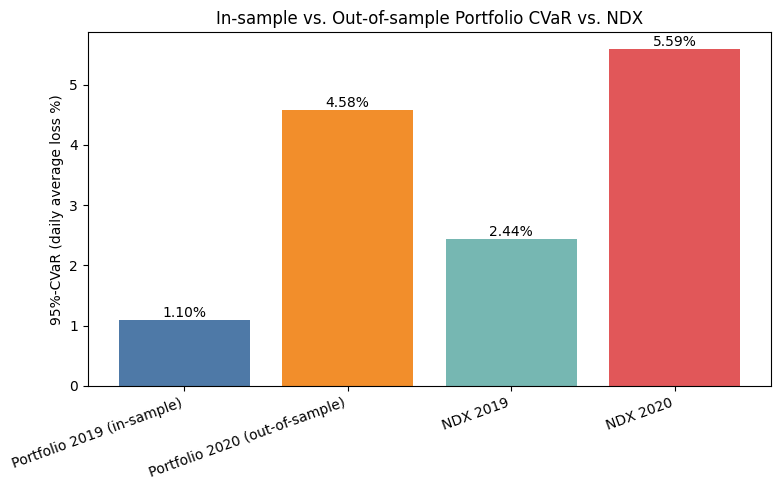

In [44]:
def empirical_var_cvar(returns_array, beta=0.95):
    # returns_array: 1D numpy array of daily returns (decimal, e.g. 0.01 = 1%)
    losses = -np.sort(returns_array)  # sorted losses largest first (loss >0)
    k = int(np.ceil((1 - beta) * len(losses)))             # number of tail obs
    if k == 0:
        return 0.0, 0.0
    var = losses[k-1]                                     # empirical VaR (loss)
    cvar = losses[:k].mean()                              # empirical CVaR (loss)
    return var, cvar
# Compute in-sample 2019 empirical CVaR using the portfolio returns series from 2019
daily_portfolio_returns_2019 = returns19.values @ x.X
var_2019_in, cvar_2019_in = empirical_var_cvar(daily_portfolio_returns_2019, beta=beta)
var_2020_out, cvar_2020_out = empirical_var_cvar(daily_portfolio_returns, beta=beta)

print(f"In-sample 2019 empirical {int(beta*100)}%-VaR (loss): {var_2019_in*100:.4f}%")
print(f"In-sample 2019 empirical {int(beta*100)}%-CVaR (loss): {cvar_2019_in*100:.4f}%")
print(f"Out-of-sample 2020 empirical {int(beta*100)}%-VaR (loss): {var_2020_out*100:.4f}%")
print(f"Out-of-sample 2020 empirical {int(beta*100)}%-CVaR (loss): {cvar_2020_out*100:.4f}%")

ndx_var_19, ndx_cvar_19 = empirical_var_cvar(ndx_returns_19, beta=beta)
ndx_var_20, ndx_cvar_20 = empirical_var_cvar(ndx_returns_20, beta=beta)
print(f"NDX 2019 {int(beta*100)}%-CVaR: {ndx_cvar_19*100:.4f}% loss")
print(f"NDX 2020 {int(beta*100)}%-CVaR: {ndx_cvar_20*100:.4f}% loss")

print("\n--- CVaR Comparison (loss %)\n")
print(f"Portfolio 2019 (in-sample) CVaR: {cvar_2019_in*100:.4f}%")
print(f"Portfolio 2020 (out-of-sample) CVaR: {cvar_2020_out*100:.4f}%")
print(f"NDX 2019 CVaR: {ndx_cvar_19*100:.4f}%")
print(f"NDX 2020 CVaR: {ndx_cvar_20*100:.4f}%")

import matplotlib.pyplot as plt

# Values (already computed above)
labels = ["Portfolio 2019 (in-sample)",
          "Portfolio 2020 (out-of-sample)",
          "NDX 2019",
          "NDX 2020"]

cvar_values = [cvar_2019_in*100,
               cvar_2020_out*100,
               ndx_cvar_19*100,
               ndx_cvar_20*100]

# Bar plot
plt.figure(figsize=(8,5))
bars = plt.bar(labels, cvar_values, color=["#4e79a7","#f28e2b","#76b7b2","#e15759"])

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height,
             f"{height:.2f}%", ha="center", va="bottom", fontsize=10)

plt.ylabel("95%-CVaR (daily average loss %)")
plt.title("In-sample vs. Out-of-sample Portfolio CVaR vs. NDX")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()


# Task 3

beta=0.90 (look at the worst 10% of cases- less conservative)

Optimal weights: [0.         0.         0.         0.         0.         0.
 0.         0.         0.04799128 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.24060492 0.01831183 0.         0.         0.04728472 0.
 0.         0.00285486 0.         0.         0.00482152 0.
 0.03066234 0.04874726 0.         0.0642853  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.01465564
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.13657255
 0.         0.         0.         0.         0.         0.04198705
 0.         0.         0.         0.03162108 0.         0.00372247
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.0529003


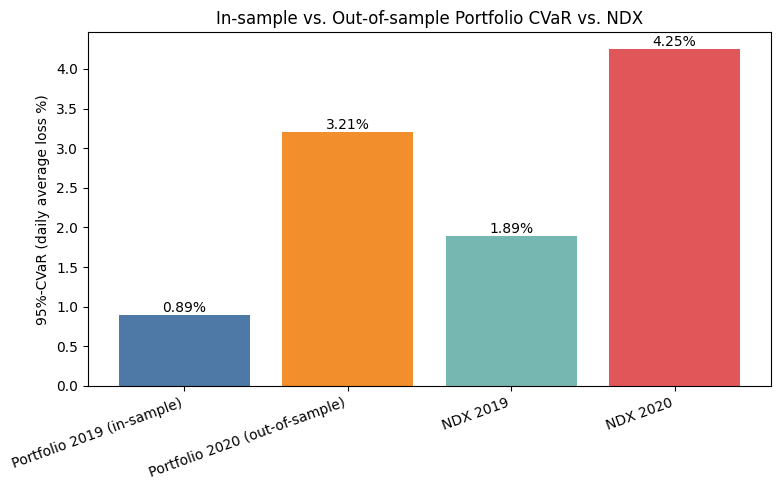

In [45]:
returns_np = returns19.values
N, n = returns_np.shape
beta = 0.90
R = 0.0002  # Minimum required average daily return

# Calculate daily mean returns for each stock
mean_returns = returns_np.mean(axis=0)

# === GUROBI MODEL ===
m = gp.Model("minimize_CVaR")

# Variables
x = m.addMVar(n, lb=0, ub=1, name="weights")
alpha = m.addVar(lb=-GRB.INFINITY, name="VaR")
z = m.addMVar(N, lb=0, name="aux_shortfall")  # z_t >= 0

# Constraints
m.addConstr(x.sum() == 1, name="weights_sum")
m.addConstr(x @ mean_returns >= R, name="min_mean_return")
m.addConstrs((z[t] >= -returns_np[t, :] @ x - alpha for t in range(N)), name="shortfall")

# Objective
obj = alpha + (1/(N*(1-beta))) * z.sum()
m.setObjective(obj, GRB.MINIMIZE)

# Solve
m.Params.OutputFlag = 0
m.optimize()

# Parameters from optimization (expressed as percentages)
mean_return = x.X @ mean_returns * 100
VaR = alpha.X * 100
CVaR = m.objVal * 100

# Results
print("Optimal weights:", x.X)
print("Optimal mean return:", round(mean_return, 2), "%")
print("Optimal VaR (alpha):", round(-VaR, 2), "%")
print("Optimal CVaR:", round(-CVaR, 2), "%")





# x.X: numpy array (n_stocks,) from 2019
# returns_20: DataFrame (n_days_2020, n_stocks), daily returns

# Compute daily portfolio returns for 2020 (not losses; returns are positive if portfolio gains)
daily_portfolio_returns = returns20.values @ x.X

# To calculate CVaR, focus on the tail of the loss distribution (worst returns)
sorted_returns = np.sort(daily_portfolio_returns)  # Sort returns: worst to best
losses = -sorted_returns  # Convert to losses, as CVaR is about loss

# Empirical quantile (VaR at beta)
VaR_idx = int(np.ceil((1-beta) * len(losses)))
VaR = losses[VaR_idx]  # VaR (quantile loss)

# CVaR: the mean of losses worse than VaR
CVaR = losses[:VaR_idx+1].mean()

print(f"Empirical daily average {int(beta*100)}%-CVaR in 2020: {CVaR*100:.4f}%")



url = "https://raw.githubusercontent.com/ethandavenport/Optimization-I-Project-1/main/stocks2019.csv"
ndx19 = pd.read_csv(url, index_col=0)['NDX']

url = "https://raw.githubusercontent.com/ethandavenport/Optimization-I-Project-1/main/stocks2020.csv"
ndx20 = pd.read_csv(url, index_col=0)['NDX']

ndxreturns19 = ndx19.pct_change().dropna(how="all")
ndxreturns20 = ndx20.pct_change().dropna(how="all")

# NDX daily returns for 2019 and 2020
ndx_returns_19 = ndxreturns19.values  # For 2019
ndx_returns_20 = ndxreturns20.values  # For 2020

# Compute CVaR for 2019
ndx_losses_19 = -np.sort(ndx_returns_19)
VaR_idx_19 = int(np.ceil((1-beta) * len(ndx_losses_19)))
VaR_ndx_19 = ndx_losses_19[VaR_idx_19]
CVaR_ndx_19 = ndx_losses_19[:VaR_idx_19+1].mean()

# Compute CVaR for 2020
ndx_losses_20 = -np.sort(ndx_returns_20)
VaR_idx_20 = int(np.ceil((1-beta) * len(ndx_losses_20)))
VaR_ndx_20 = ndx_losses_20[VaR_idx_20]
CVaR_ndx_20 = ndx_losses_20[:VaR_idx_20+1].mean()

print(f"Empirical daily average {int(beta*100)}%-CVaR of NDX (2019): {-CVaR_ndx_19*100:.4f}%")
print(f"Empirical daily average {int(beta*100)}%-CVaR of NDX (2020): {-CVaR_ndx_20*100:.4f}%")





def empirical_var_cvar(returns_array, beta=0.95):
    # returns_array: 1D numpy array of daily returns (decimal, e.g. 0.01 = 1%)
    losses = -np.sort(returns_array)  # sorted losses largest first (loss >0)
    k = int(np.ceil((1 - beta) * len(losses)))             # number of tail obs
    if k == 0:
        return 0.0, 0.0
    var = losses[k-1]                                     # empirical VaR (loss)
    cvar = losses[:k].mean()                              # empirical CVaR (loss)
    return var, cvar
# Compute in-sample 2019 empirical CVaR using the portfolio returns series from 2019
daily_portfolio_returns_2019 = returns19.values @ x.X
var_2019_in, cvar_2019_in = empirical_var_cvar(daily_portfolio_returns_2019, beta=beta)
var_2020_out, cvar_2020_out = empirical_var_cvar(daily_portfolio_returns, beta=beta)

print(f"In-sample 2019 empirical {int(beta*100)}%-VaR (loss): {var_2019_in*100:.4f}%")
print(f"In-sample 2019 empirical {int(beta*100)}%-CVaR (loss): {cvar_2019_in*100:.4f}%")
print(f"Out-of-sample 2020 empirical {int(beta*100)}%-VaR (loss): {var_2020_out*100:.4f}%")
print(f"Out-of-sample 2020 empirical {int(beta*100)}%-CVaR (loss): {cvar_2020_out*100:.4f}%")

ndx_var_19, ndx_cvar_19 = empirical_var_cvar(ndx_returns_19, beta=beta)
ndx_var_20, ndx_cvar_20 = empirical_var_cvar(ndx_returns_20, beta=beta)
print(f"NDX 2019 {int(beta*100)}%-CVaR: {ndx_cvar_19*100:.4f}% loss")
print(f"NDX 2020 {int(beta*100)}%-CVaR: {ndx_cvar_20*100:.4f}% loss")

print("\n--- CVaR Comparison (loss %)\n")
print(f"Portfolio 2019 (in-sample) CVaR: {cvar_2019_in*100:.4f}%")
print(f"Portfolio 2020 (out-of-sample) CVaR: {cvar_2020_out*100:.4f}%")
print(f"NDX 2019 CVaR: {ndx_cvar_19*100:.4f}%")
print(f"NDX 2020 CVaR: {ndx_cvar_20*100:.4f}%")

import matplotlib.pyplot as plt

# Values (already computed above)
labels = ["Portfolio 2019 (in-sample)",
          "Portfolio 2020 (out-of-sample)",
          "NDX 2019",
          "NDX 2020"]

cvar_values = [cvar_2019_in*100,
               cvar_2020_out*100,
               ndx_cvar_19*100,
               ndx_cvar_20*100]

# Bar plot
plt.figure(figsize=(8,5))
bars = plt.bar(labels, cvar_values, color=["#4e79a7","#f28e2b","#76b7b2","#e15759"])

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height,
             f"{height:.2f}%", ha="center", va="bottom", fontsize=10)

plt.ylabel("95%-CVaR (daily average loss %)")
plt.title("In-sample vs. Out-of-sample Portfolio CVaR vs. NDX")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()


beta=0.99 (look at the worst 1% of cases- very conservative)

Optimal weights: [0.         0.         0.         0.         0.         0.
 0.         0.         0.03630875 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.24805506 0.         0.         0.         0.08907388 0.
 0.         0.         0.         0.         0.00818906 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.06726877
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.05100548 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.00646252 0.         0.04660145
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         

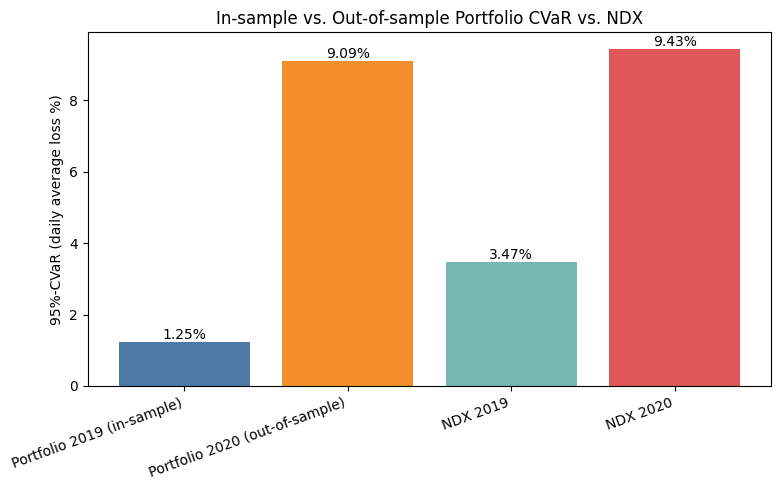

In [46]:
returns_np = returns19.values
N, n = returns_np.shape
beta = 0.99
R = 0.0002  # Minimum required average daily return

# Calculate daily mean returns for each stock
mean_returns = returns_np.mean(axis=0)

# === GUROBI MODEL ===
m = gp.Model("minimize_CVaR")

# Variables
x = m.addMVar(n, lb=0, ub=1, name="weights")
alpha = m.addVar(lb=-GRB.INFINITY, name="VaR")
z = m.addMVar(N, lb=0, name="aux_shortfall")  # z_t >= 0

# Constraints
m.addConstr(x.sum() == 1, name="weights_sum")
m.addConstr(x @ mean_returns >= R, name="min_mean_return")
m.addConstrs((z[t] >= -returns_np[t, :] @ x - alpha for t in range(N)), name="shortfall")

# Objective
obj = alpha + (1/(N*(1-beta))) * z.sum()
m.setObjective(obj, GRB.MINIMIZE)

# Solve
m.Params.OutputFlag = 0
m.optimize()

# Parameters from optimization (expressed as percentages)
mean_return = x.X @ mean_returns * 100
VaR = alpha.X * 100
CVaR = m.objVal * 100

# Results
print("Optimal weights:", x.X)
print("Optimal mean return:", round(mean_return, 2), "%")
print("Optimal VaR (alpha):", round(-VaR, 2), "%")
print("Optimal CVaR:", round(-CVaR, 2), "%")

# x.X: numpy array (n_stocks,) from 2019
# returns_20: DataFrame (n_days_2020, n_stocks), daily returns

# Compute daily portfolio returns for 2020 (not losses; returns are positive if portfolio gains)
daily_portfolio_returns = returns20.values @ x.X

# To calculate CVaR, focus on the tail of the loss distribution (worst returns)
sorted_returns = np.sort(daily_portfolio_returns)  # Sort returns: worst to best
losses = -sorted_returns  # Convert to losses, as CVaR is about loss

# Empirical quantile (VaR at beta)
VaR_idx = int(np.ceil((1-beta) * len(losses)))
VaR = losses[VaR_idx]  # VaR (quantile loss)

# CVaR: the mean of losses worse than VaR
CVaR = losses[:VaR_idx+1].mean()

print(f"Empirical daily average {int(beta*100)}%-CVaR in 2020: {CVaR*100:.4f}%")

url = "https://raw.githubusercontent.com/ethandavenport/Optimization-I-Project-1/main/stocks2019.csv"
ndx19 = pd.read_csv(url, index_col=0)['NDX']

url = "https://raw.githubusercontent.com/ethandavenport/Optimization-I-Project-1/main/stocks2020.csv"
ndx20 = pd.read_csv(url, index_col=0)['NDX']

ndxreturns19 = ndx19.pct_change().dropna(how="all")
ndxreturns20 = ndx20.pct_change().dropna(how="all")

# NDX daily returns for 2019 and 2020
ndx_returns_19 = ndxreturns19.values  # For 2019
ndx_returns_20 = ndxreturns20.values  # For 2020

# Compute CVaR for 2019
ndx_losses_19 = -np.sort(ndx_returns_19)
VaR_idx_19 = int(np.ceil((1-beta) * len(ndx_losses_19)))
VaR_ndx_19 = ndx_losses_19[VaR_idx_19]
CVaR_ndx_19 = ndx_losses_19[:VaR_idx_19+1].mean()

# Compute CVaR for 2020
ndx_losses_20 = -np.sort(ndx_returns_20)
VaR_idx_20 = int(np.ceil((1-beta) * len(ndx_losses_20)))
VaR_ndx_20 = ndx_losses_20[VaR_idx_20]
CVaR_ndx_20 = ndx_losses_20[:VaR_idx_20+1].mean()

print(f"Empirical daily average {int(beta*100)}%-CVaR of NDX (2019): {-CVaR_ndx_19*100:.4f}%")
print(f"Empirical daily average {int(beta*100)}%-CVaR of NDX (2020): {-CVaR_ndx_20*100:.4f}%")

def empirical_var_cvar(returns_array, beta=0.95):
    # returns_array: 1D numpy array of daily returns (decimal, e.g. 0.01 = 1%)
    losses = -np.sort(returns_array)  # sorted losses largest first (loss >0)
    k = int(np.ceil((1 - beta) * len(losses)))             # number of tail obs
    if k == 0:
        return 0.0, 0.0
    var = losses[k-1]                                     # empirical VaR (loss)
    cvar = losses[:k].mean()                              # empirical CVaR (loss)
    return var, cvar
# Compute in-sample 2019 empirical CVaR using the portfolio returns series from 2019
daily_portfolio_returns_2019 = returns19.values @ x.X
var_2019_in, cvar_2019_in = empirical_var_cvar(daily_portfolio_returns_2019, beta=beta)
var_2020_out, cvar_2020_out = empirical_var_cvar(daily_portfolio_returns, beta=beta)

print(f"In-sample 2019 empirical {int(beta*100)}%-VaR (loss): {var_2019_in*100:.4f}%")
print(f"In-sample 2019 empirical {int(beta*100)}%-CVaR (loss): {cvar_2019_in*100:.4f}%")
print(f"Out-of-sample 2020 empirical {int(beta*100)}%-VaR (loss): {var_2020_out*100:.4f}%")
print(f"Out-of-sample 2020 empirical {int(beta*100)}%-CVaR (loss): {cvar_2020_out*100:.4f}%")

ndx_var_19, ndx_cvar_19 = empirical_var_cvar(ndx_returns_19, beta=beta)
ndx_var_20, ndx_cvar_20 = empirical_var_cvar(ndx_returns_20, beta=beta)
print(f"NDX 2019 {int(beta*100)}%-CVaR: {ndx_cvar_19*100:.4f}% loss")
print(f"NDX 2020 {int(beta*100)}%-CVaR: {ndx_cvar_20*100:.4f}% loss")

print("\n--- CVaR Comparison (loss %)\n")
print(f"Portfolio 2019 (in-sample) CVaR: {cvar_2019_in*100:.4f}%")
print(f"Portfolio 2020 (out-of-sample) CVaR: {cvar_2020_out*100:.4f}%")
print(f"NDX 2019 CVaR: {ndx_cvar_19*100:.4f}%")
print(f"NDX 2020 CVaR: {ndx_cvar_20*100:.4f}%")

import matplotlib.pyplot as plt

# Values (already computed above)
labels = ["Portfolio 2019 (in-sample)",
          "Portfolio 2020 (out-of-sample)",
          "NDX 2019",
          "NDX 2020"]

cvar_values = [cvar_2019_in*100,
               cvar_2020_out*100,
               ndx_cvar_19*100,
               ndx_cvar_20*100]

# Bar plot
plt.figure(figsize=(8,5))
bars = plt.bar(labels, cvar_values, color=["#4e79a7","#f28e2b","#76b7b2","#e15759"])

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height,
             f"{height:.2f}%", ha="center", va="bottom", fontsize=10)

plt.ylabel("95%-CVaR (daily average loss %)")
plt.title("In-sample vs. Out-of-sample Portfolio CVaR vs. NDX")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()


# Task 4

In [47]:
beta = 0.95            # risk level (change for experiments)
R = 0.0002             # minimum required average daily return (same as Task 2)

# Basic dimensions
dates = returns19.index
N = len(returns19)                # total days
tickers = returns19.columns.tolist()
n = len(tickers)                  # number of stocks

# Precompute mean returns (daily) used in R constraint
mean_returns = returns19.mean(axis=0).values  # shape (n,)

# Convert index to DatetimeIndex
returns19.index = pd.to_datetime(returns19.index)


# ---------- Helper: group indices by month ----------
# Create mapping month_str -> list of integer row indices in returns19
# month_str format: "YYYY-MM"
months = returns19.index.to_period('M').astype(str)
unique_months = months.unique().tolist()  # months in chronological order
month_to_indices = {m: np.where(months == m)[0].tolist() for m in unique_months}
M = len(unique_months)

# ---------- Build model: minimize maximum monthly CVaR ----------
model_maxmonth = gp.Model("minimize_max_monthly_CVaR")
model_maxmonth.Params.OutputFlag = 0  # silent

# Decision vars:
# x: portfolio weights
x = model_maxmonth.addMVar(shape=n, lb=0.0, ub=1.0, name="x")

# For each month m we will create:
# alpha_m (scalar) and u_m (one per day in that month)
alpha_month = {}
u_month = {}

for m in unique_months:
    Nm = len(month_to_indices[m])
    alpha_month[m] = model_maxmonth.addVar(lb=-GRB.INFINITY, name=f"alpha_{m}")
    # u_m is a vector of length Nm, u >= 0
    if Nm > 0:
        u_month[m] = model_maxmonth.addMVar(shape=Nm, lb=0.0, name=f"u_{m}")
    else:
        u_month[m] = None  # just in case

# z_max: the maximum over monthly CVaR values (objective minimize z_max)
z_max = model_maxmonth.addVar(lb=-GRB.INFINITY, name="z_max")

# Constraints for portfolio
model_maxmonth.addConstr(x.sum() == 1.0, name="weights_sum")
model_maxmonth.addConstr(x @ mean_returns >= R, name="min_mean_return")

# For each month, build the linear CVaR expression and constrain CVaR_m <= z_max
for m in unique_months:
    idx = month_to_indices[m]
    Nm = len(idx)
    if Nm == 0:
        # skip empty month (shouldn't happen)
        continue

    # For each day t in that month: u_mt >= -x^T y_t - alpha_m
    # We'll collect portfolio return expressions for those days
    # returns19.values is (N, n), row t corresponds to returns of tickers for date t
    rows = returns19.values[idx, :]  # shape (Nm, n)
    # Build constraints: for day i in month m:
    # u_month[m][i] >= - rows[i] @ x - alpha_month[m]
    for i in range(Nm):
        model_maxmonth.addConstr(
            u_month[m][i] >= - (rows[i] @ x) - alpha_month[m],
            name=f"shortfall_{m}_{i}"
        )
    # CVaR_m = alpha_m + (1/((1-beta)*Nm)) * sum(u_m)
    denom = (1.0 - beta) * Nm
    if denom <= 0:
        raise ValueError("Denominator for CVaR is non-positive; check beta and month sizes.")
    CVaR_m_expr = alpha_month[m] + (1.0 / denom) * u_month[m].sum()
    # Enforce CVaR_m <= z_max
    model_maxmonth.addConstr(CVaR_m_expr <= z_max, name=f"maxmonth_leq_z_{m}")

# Objective: minimize z_max
model_maxmonth.setObjective(z_max, GRB.MINIMIZE)

# Solve
model_maxmonth.optimize()

# Extract solution
weights_maxmonth = x.X.copy()
alpha_month_vals = {m: alpha_month[m].X for m in unique_months}
z_max_val = z_max.X

# ---------- Compute diagnostic statistics for the found weights ----------
def empirical_monthly_cvar_for_weights(weights, returns_df, beta):
    """
    returns:
      monthly_cvars: dict month->(CVaR_value, VaR_value)
      avg_daily_cvar: average daily CVaR across all days (like Task 2 objective scaled to days)
      max_monthly_cvar: max of monthly CVaR
    All CVaR/VaR values are in decimal (e.g., 0.01 = 1%)
    """
    months = returns_df.index.to_period('M').astype(str)
    unique_m = months.unique().tolist()
    monthly_cvars = {}
    all_losses = []
    N_total = len(returns_df)
    for m in unique_m:
        idx = np.where(months == m)[0]
        if len(idx) == 0:
            continue
        # daily portfolio returns (for that month)
        r = returns_df.values[idx, :] @ weights  # shape (Nm,)
        losses = -r  # losses
        losses_sorted = np.sort(losses)  # ascending (worst to best)
        k = int(np.floor((1 - beta) * len(losses_sorted)))  # index of cutoff
        if k < 1:
            # if (1-beta)*Nm < 1, treat CVaR as mean of worst 1 sample -> take worst loss
            VaR = losses_sorted[0]
            CVaR = losses_sorted[0]
        else:
            VaR = losses_sorted[k-1]  # empirical quantile (conservative)
            CVaR = losses_sorted[:k].mean()
        monthly_cvars[m] = {"CVaR": CVaR, "VaR": VaR, "N": len(idx)}
        all_losses.extend(list(losses))
    # avg daily CVaR estimate: compute empirical alpha and u across all days (like Task 2)
    all_losses_arr = np.array(all_losses)
    all_losses_sorted = np.sort(all_losses_arr)
    k_all = int(np.floor((1 - beta) * len(all_losses_sorted)))
    if k_all < 1:
        avg_daily_cvar = all_losses_sorted[0]
    else:
        avg_daily_cvar = all_losses_sorted[:k_all].mean()

    max_monthly_cvar = max([v["CVaR"] for v in monthly_cvars.values()])
    return monthly_cvars, avg_daily_cvar, max_monthly_cvar

monthly_cvars_maxmonth, avg_daily_cvar_maxmonth, max_monthly_cvar_sol = empirical_monthly_cvar_for_weights(
    weights_maxmonth, returns19, beta
)

# ---------- For comparison: re-run Task 2 (minimize average CVaR over all days) ----------
# Build the 'average-daily CVaR' model like you had in Task 2
# Use the same mean_returns, R, returns19.values, beta
model_avg = gp.Model("minimize_avg_CVaR")
model_avg.Params.OutputFlag = 0

x_avg = model_avg.addMVar(shape=n, lb=0.0, ub=1.0, name="x")
alpha_avg = model_avg.addVar(lb=-GRB.INFINITY, name="alpha_avg")
u_all = model_avg.addMVar(shape=N, lb=0.0, name="u_all")

# constraints
model_avg.addConstr(x_avg.sum() == 1.0, name="weights_sum")
model_avg.addConstr(x_avg @ mean_returns >= R, name="min_mean_return")

# scenario constraints
rows_all = returns19.values  # shape (N, n)
for t in range(N):
    model_avg.addConstr(u_all[t] >= - (rows_all[t] @ x_avg) - alpha_avg, name=f"shortfall_all_{t}")

# objective: alpha + (1/((1-beta)*N)) * sum(u_all)
denom_all = (1.0 - beta) * float(N)
model_avg.setObjective(alpha_avg + (1.0 / denom_all) * u_all.sum(), GRB.MINIMIZE)

model_avg.optimize()

weights_avg = x_avg.X.copy()
alpha_avg_val = alpha_avg.X
obj_avg_val = model_avg.objVal

# Diagnostics for avg solution
monthly_cvars_avg, avg_daily_cvar_avg, max_monthly_cvar_avg = empirical_monthly_cvar_for_weights(
    weights_avg, returns19, beta
)

# ---------- Print comparison ----------
def print_top_k_weights(weights, tickers, k=10):
    dfw = pd.DataFrame({"ticker": tickers, "weight": weights})
    dfw_sorted = dfw.sort_values("weight", ascending=False).reset_index(drop=True)
    print(dfw_sorted.head(k).to_string(index=False))

print("=== Comparison of strategies (beta = {:.2f}) ===".format(beta))
print("\nStrategy A: Minimize maximum monthly CVaR (objective: minimize worst-month CVaR)")
print(f"Objective (z_max) value: {z_max_val:.6f} (decimal, e.g. 0.01 = 1%)")
print(f"Empirical avg daily CVaR (computed from 2019 data using solution): {avg_daily_cvar_maxmonth:.6f}")
print(f"Empirical max monthly CVaR (computed from 2019 data): {max_monthly_cvar_sol:.6f}")
print("Top weights (strategy A):")
print_top_k_weights(weights_maxmonth, tickers, k=8)

print("\nStrategy B: Minimize average daily CVaR (Task 2 style)")
print(f"Objective (model avg CVaR) value: {obj_avg_val:.6f}")
print(f"Empirical avg daily CVaR (computed from 2019 data using solution): {avg_daily_cvar_avg:.6f}")
print(f"Empirical max monthly CVaR (computed from 2019 data): {max_monthly_cvar_avg:.6f}")
print("Top weights (strategy B):")
print_top_k_weights(weights_avg, tickers, k=8)

# Also print a short numeric comparison
print("\nNumeric comparison (percent):")
print(f"Strategy A: avg daily CVaR = {avg_daily_cvar_maxmonth*100:.4f}%, max monthly CVaR = {max_monthly_cvar_sol*100:.4f}%")
print(f"Strategy B: avg daily CVaR = {avg_daily_cvar_avg*100:.4f}%, max monthly CVaR = {max_monthly_cvar_avg*100:.4f}%")

=== Comparison of strategies (beta = 0.95) ===

Strategy A: Minimize maximum monthly CVaR (objective: minimize worst-month CVaR)
Objective (z_max) value: 0.012446 (decimal, e.g. 0.01 = 1%)
Empirical avg daily CVaR (computed from 2019 data using solution): -0.018488
Empirical max monthly CVaR (computed from 2019 data): -0.006780
Top weights (strategy A):
ticker   weight
   XEL 0.450306
  CHTR 0.243467
  CTXS 0.089679
   KHC 0.067274
  NTES 0.051131
  SPLK 0.046933
  AMGN 0.035447
  DXCM 0.008380

Strategy B: Minimize average daily CVaR (Task 2 style)
Objective (model avg CVaR) value: 0.011090
Empirical avg daily CVaR (computed from 2019 data using solution): -0.017462
Empirical max monthly CVaR (computed from 2019 data): -0.006776
Top weights (strategy B):
ticker   weight
   XEL 0.303917
  CHTR 0.264965
  AMGN 0.080766
  CTXS 0.065614
  CHKP 0.062696
   EXC 0.052155
   KHC 0.040510
   CSX 0.034312

Numeric comparison (percent):
Strategy A: avg daily CVaR = -1.8488%, max monthly CVaR = -

# Task 5

In [48]:
from datetime import timedelta

# Combined data for rolling windows
returns_all = pd.concat([returns19, returns20])
returns_all.index = pd.to_datetime(returns_all.index, format='mixed')

beta = 0.95
R = 0.0002  # Min required daily return

def optimize_portfolio(returns, beta=0.95, R=0.0002):
    """Optimize CVaR portfolio using past return data."""
    returns_np = returns.values
    N, n = returns_np.shape
    mean_returns = returns_np.mean(axis=0)

    m = gp.Model("minimize_CVaR")
    x = m.addMVar(n, lb=0, ub=1, name="weights")
    alpha = m.addVar(lb=-GRB.INFINITY, name="VaR")
    z = m.addMVar(N, lb=0, name="shortfall")

    m.addConstr(x.sum() == 1)
    m.addConstr(x @ mean_returns >= R)
    m.addConstrs((z[t] >= -returns_np[t, :] @ x - alpha for t in range(N)))

    obj = alpha + (1/(N*(1-beta))) * z.sum()
    m.setObjective(obj, GRB.MINIMIZE)
    m.Params.OutputFlag = 0
    m.optimize()

    return x.X  # optimized weights

# Store monthly CVaRs and portfolios
monthly_cvars = []
monthly_weights = {}
returns20.index = pd.to_datetime(returns20.index)
monthly_dates = returns20.index.to_period("M").unique()

for month in monthly_dates:
    # Define training window: 1 year ending at the last day of previous month
    end_train = pd.Period(month, freq='M').start_time - timedelta(days=1)
    start_train = end_train - pd.DateOffset(years=1) + timedelta(days=1)
    train_window = returns_all.loc[start_train:end_train]

    # Optimize portfolio using 1-year window
    weights = optimize_portfolio(train_window, beta=beta, R=R)
    monthly_weights[str(month)] = weights

    # Apply weights to compute returns in this month
    test_window = returns20.loc[month.start_time:month.end_time]
    daily_returns = test_window.values @ weights

    # Compute monthly CVaR
    sorted_losses = -np.sort(daily_returns)
    var_idx = int(np.ceil((1 - beta) * len(sorted_losses)))
    cvar = sorted_losses[:var_idx + 1].mean()
    monthly_cvars.append(cvar)

# Convert to numpy for summary stats
monthly_cvars = np.array(monthly_cvars)

# Summary stats
print(f"Avg monthly CVaR: {monthly_cvars.mean()*100:.4f}%")
print(f"Std dev of monthly CVaR: {monthly_cvars.std()*100:.4f}%")
print(f"Min monthly CVaR: {monthly_cvars.min()*100:.4f}%")
print(f"Max monthly CVaR: {monthly_cvars.max()*100:.4f}%")

/tmp/ipython-input-3180015815.py:35: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  returns20.index = pd.to_datetime(returns20.index)


Avg monthly CVaR: 2.5192%
Std dev of monthly CVaR: 1.8578%
Min monthly CVaR: 0.6439%
Max monthly CVaR: 8.0911%


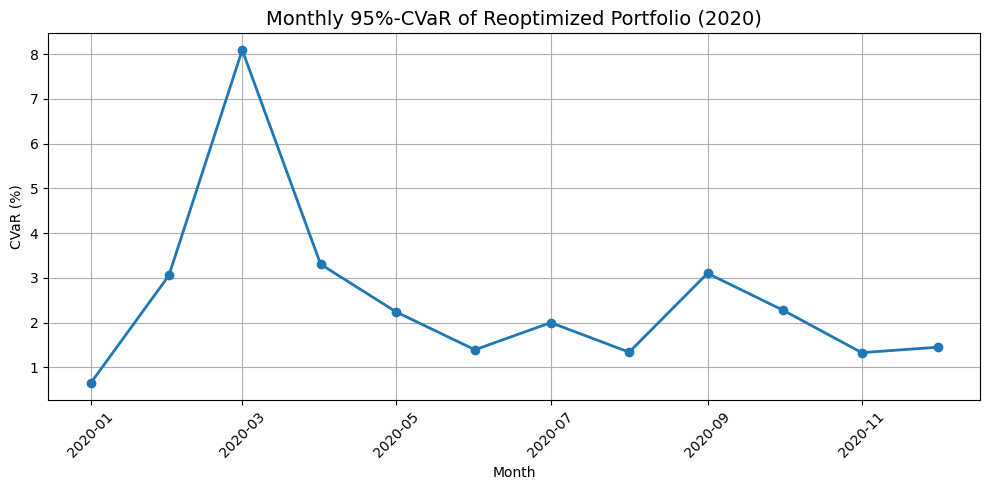

In [49]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert monthly_cvars to Series with datetime index
monthly_cvar_series = pd.Series(monthly_cvars, index=monthly_dates.to_timestamp())

# Line plot of monthly CVaR
plt.figure(figsize=(10, 5))
plt.plot(monthly_cvar_series.index, monthly_cvar_series * 100, marker='o', linewidth=2)
plt.title("Monthly 95%-CVaR of Reoptimized Portfolio (2020)", fontsize=14)
plt.ylabel("CVaR (%)")
plt.xlabel("Month")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Task 6

Is the portfolio sequence stable? False

Maximum month-to-month change in weights (non-zero only):
AMZN    0.001747
AMGN    0.085763
CERN    0.083966
CHTR    0.296739
CHKP    0.089608
CTXS    0.451674
CTSH    0.015251
COST    0.289998
CSX     0.044288
DXCM    0.057476
DOCU    0.125847
DLTR    0.074775
EBAY    0.167736
EA      0.009700
EXC     0.065702
GILD    0.154766
INCY    0.091903
JD      0.030386
KHC     0.111156
LULU    0.001802
MAR     0.103610
MRNA    0.062643
NTES    0.106401
ORLY    0.038058
PDD     0.074720
REGN    0.008700
TMUS    0.009020
TTWO    0.026517
XEL     0.332126
dtype: float64


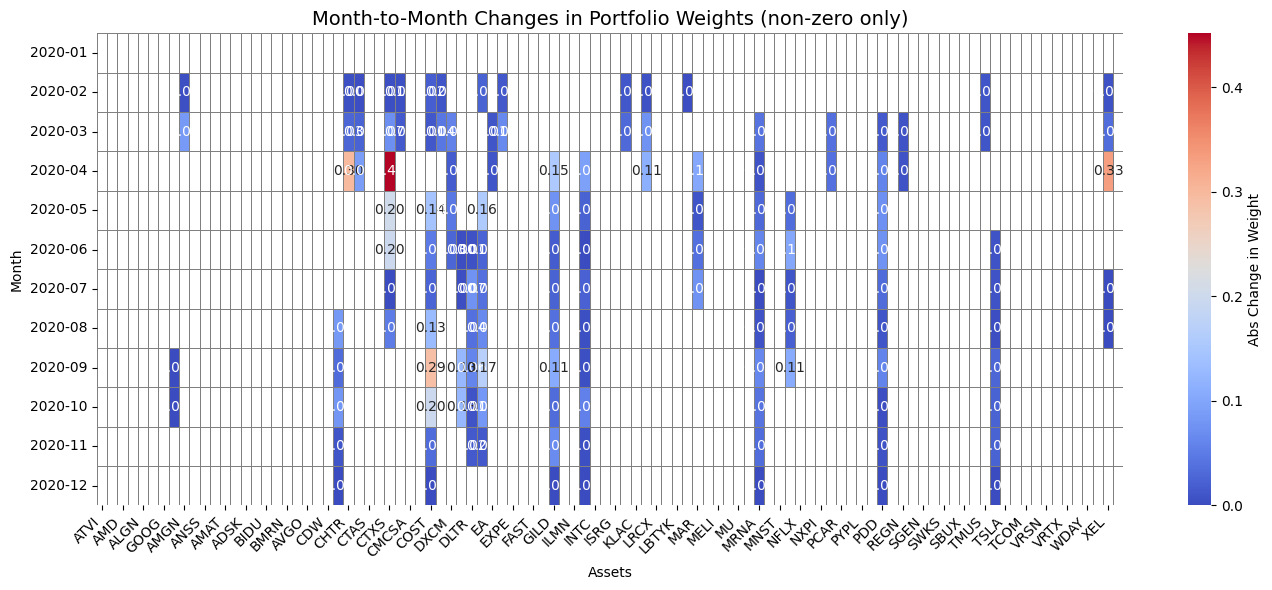

In [50]:
import seaborn as sns
import numpy as np

# =========================================
# 1. Convert dictionary to DataFrame
# =========================================
asset_names = returns20.columns.tolist()

monthly_weights_df = pd.DataFrame.from_dict(monthly_weights, orient="index")
monthly_weights_df.columns = asset_names
monthly_weights_df.index = pd.to_datetime(monthly_weights_df.index)
monthly_weights_df = monthly_weights_df.sort_index()

# =========================================
# 2. Compute differences and check stability
# =========================================
weight_diffs = monthly_weights_df.diff().abs()

# Filter only columns (assets) that have at least one non-zero change
nonzero_cols = weight_diffs.loc[:, (weight_diffs != 0).any(axis=0)]

# Also keep rows where there’s some nonzero activity
nonzero_diffs = nonzero_cols.loc[(nonzero_cols != 0).any(axis=1)]

# Check stability
is_stable = (weight_diffs <= 0.05).all().all()
print("Is the portfolio sequence stable?", is_stable)

# Show maximum change per asset (only unstable ones)
max_change = nonzero_cols.max()
print("\nMaximum month-to-month change in weights (non-zero only):")
print(max_change[max_change > 0])

# =========================================
# 3. Heatmap visualization (cleaner)
# =========================================
# Convert index to Year-Month strings
nonzero_diffs.index = nonzero_diffs.index.strftime("%Y-%m")

plt.figure(figsize=(14, 6))

# Mask zeros so they show as blank
mask = nonzero_diffs == 0

sns.heatmap(
    nonzero_diffs,
    annot=True, fmt=".2f",
    cmap="coolwarm",
    mask=mask,
    cbar_kws={'label': 'Abs Change in Weight'},
    linewidths=0.4, linecolor="gray"
)

plt.title("Month-to-Month Changes in Portfolio Weights (non-zero only)", fontsize=14)
plt.xlabel("Assets")
plt.ylabel("Month")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


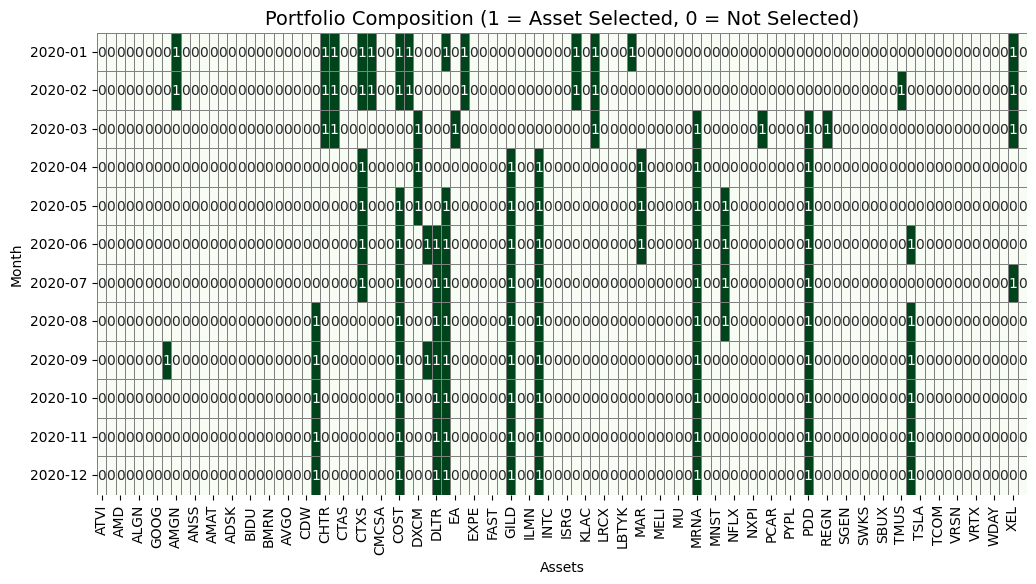

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assume monthly_weights_df is already built (from Task 5 portfolios)
# Rows = months, Columns = assets

# Convert weights to binary (1 if nonzero, 0 otherwise)
binary_allocations = (monthly_weights_df > 0).astype(int)

# Format index for display
binary_allocations.index = binary_allocations.index.strftime("%Y-%m")

plt.figure(figsize=(12,6))
sns.heatmap(
    binary_allocations,
    cmap="Greens",
    cbar=False,
    linewidths=0.5, linecolor="gray",
    annot=True, fmt="d"
)
plt.title("Portfolio Composition (1 = Asset Selected, 0 = Not Selected)", fontsize=14)
plt.xlabel("Assets")
plt.ylabel("Month")
plt.show()
